<p align="center">
  <img src="./imgs/mne_logo.jpg" alt="image" width="50%" height="auto" />
</p>

# MNE-Python Workshop
Cutting EEG Conference                 
Presentation by: Sara Rostami, Alireza Mahdavi
***

## Part 3: Multivariate Pattern Analysis (MVPA)

In [1]:
%matplotlib inline
import mne
import matplotlib.pyplot as plt

fname = "./oddball-epo.fif"
epochs = mne.read_epochs(fname)

mne.set_log_level(True)

event_ids = {"standard/stimulus": 200, "target/stimulus": 100}

Reading s:\Work\M.S\CuttingEEG-Conference\mne_workshop_amsterdam-master\oddball-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated


## MVPA/decoding

Can we predict trial type from EEG activity?

In [2]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [3]:
epochs.pick_types(eeg=True)
X = epochs.get_data()  # features
y = epochs.events[:, -1] == event_ids["target/stimulus"]  # targets
X.shape, y.shape

((212, 63, 71), (212,))

In [4]:
y[:9]

array([ True, False,  True, False,  True, False,  True, False, False])

X has the wrong shape - `samples`, `channels`, `times`, should be `samples`, `features`.

We can use `mne.decoding.Vectorizer` to correctly shape the data. It fits right into a scikit-learn pipeline.

In [5]:
from mne.decoding import Vectorizer
clf = make_pipeline(Vectorizer(), StandardScaler(),
                    LinearSVC(class_weight="balanced")
                   )

In [24]:
LinearSVC?

Init signature:
LinearSVC(
    penalty='l2',
    loss='squared_hinge',
    *,
    dual=True,
    tol=0.0001,
    C=1.0,
    multi_class='ovr',
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    verbose=0,
    random_state=None,
    max_iter=1000,
)
Docstring:     
Linear Support Vector Classification.

Similar to SVC with parameter kernel='linear', but implemented in terms of
liblinear rather than libsvm, so it has more flexibility in the choice of
penalties and loss functions and should scale better to large numbers of
samples.

This class supports both dense and sparse input and the multiclass support
is handled according to a one-vs-the-rest scheme.

Read more in the :ref:`User Guide <svm_classification>`.

Parameters
----------
penalty : {'l1', 'l2'}, default='l2'
    Specifies the norm used in the penalization. The 'l2'
    penalty is the standard used in SVC. The 'l1' leads to ``coef_``
    vectors that are sparse.

loss : {'hinge', 'squared_hinge'}, defa

The resulting object behaves exactly as any other scikit-learn classifier:

In [6]:
clf.fit(X, y)

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x000001CD01DBEA48>),
                ('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(class_weight='balanced'))])

In [7]:
clf.predict(X[:9])

array([ True, False,  True, False,  True, False,  True, False, False])

Of course, usually we care about cross-validated scores.

In [8]:
cross_val_score(clf, X, y)  # accuracy

array([0.69767442, 0.8372093 , 0.83333333, 0.78571429, 0.66666667])

So there is some decodable information in the brain data. Can we investigate this in a bit more detail?
For example: at which time points in the trial is there information about trial category?

We need two more tools for this: one to train and score at each time point, and one to handle the cross-validated scoring for the former.

In [9]:
from mne.decoding import SlidingEstimator, cross_val_multiscore
sl = SlidingEstimator(clf)

In [10]:
scores_time_decoding = cross_val_multiscore(sl, X, y)

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

In [11]:
scores_time_decoding.shape

(5, 71)

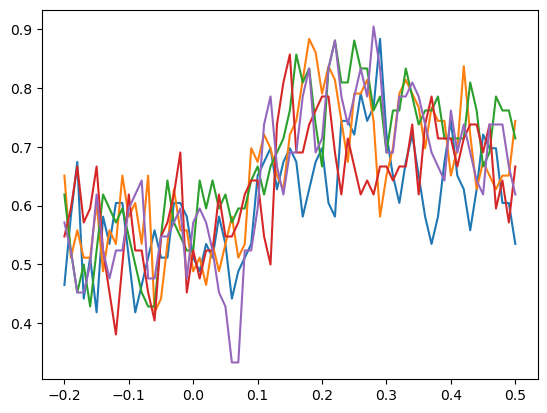

In [12]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_time_decoding.T)
plt.show()

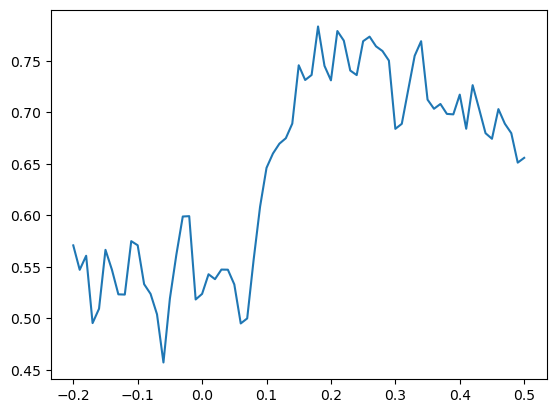

In [13]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_time_decoding.mean(0))
plt.show()

But is the same thing happening at each time point? We can investigate that with generalization across time decoding.

In [15]:
from mne.decoding import GeneralizingEstimator
gen = GeneralizingEstimator(clf)
scores_gat = cross_val_multiscore(gen, X, y)

  0%|          | Fitting GeneralizingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Scoring GeneralizingEstimator : 0/5041 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Scoring GeneralizingEstimator : 0/5041 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Scoring GeneralizingEstimator : 0/5041 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Scoring GeneralizingEstimator : 0/5041 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/71 [00:00<?,       ?it/s]

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda

  0%|          | Scoring GeneralizingEstimator : 0/5041 [00:00<?,       ?it/s]

In [16]:
scores_gat.shape

(5, 71, 71)

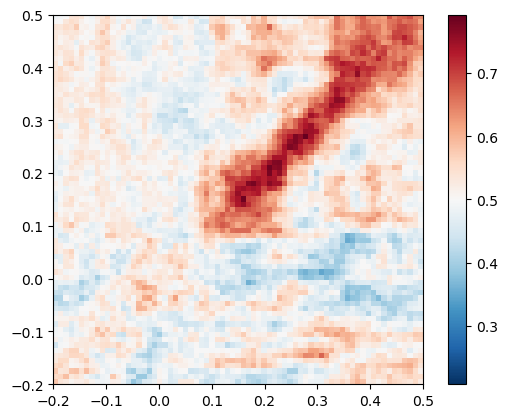

In [17]:
import numpy as np
data = scores_gat.mean(0)
vmax = np.abs(data).max()
tmin, tmax = epochs.times[[0, -1]]

fig, ax = plt.subplots()
im = ax.imshow(
    data,
    origin="lower", cmap="RdBu_r",
    extent=(tmin, tmax, tmin, tmax),
    vmax=vmax, vmin=1-vmax);

plt.colorbar(im)

We can easily attempt more complex decoding pipelines.

In [18]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

In [19]:
pca = UnsupervisedSpatialFilter(PCA(.85))

In [20]:
pca_clf = make_pipeline(pca, Vectorizer(), StandardScaler(), LinearSVC())

In [21]:
cross_val_score(pca_clf, X, y)

c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\Sara Rostami.D\.conda\envs\base2\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


array([0.65116279, 0.81395349, 0.76190476, 0.64285714, 0.57142857])

What do the learned patterns actually look like?

No projector specified for this dataset. Please consider the method self.add_proj.


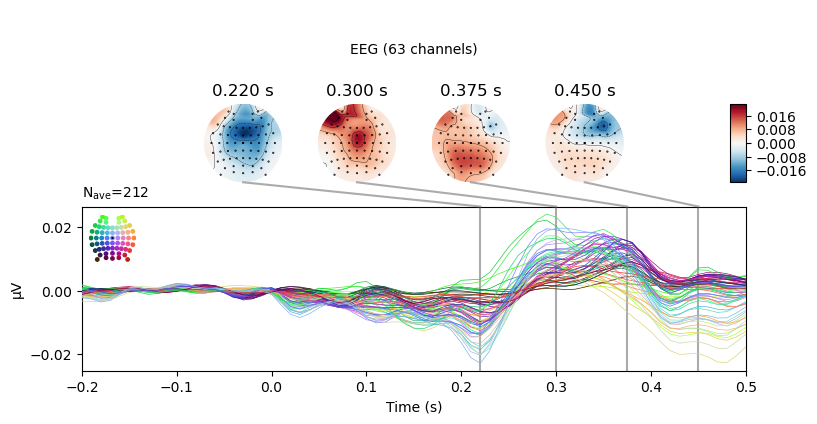

In [22]:
svc = LinearSVC(class_weight="balanced")
topos = np.array([svc.fit(time_point.T, y).coef_ * time_point.std(1)
                  for time_point in X.T])[:, 0, :]
topo_ev = mne.EvokedArray(topos.T, info=epochs.info, tmin=-.2, nave=len(y))
topo_ev.plot_joint(times=[.22, .3, .375, .45]);